In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap

import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

temp=pd.read_csv('/Users/yliu/Downloads/temperatures_may.csv')

## Q 0: Data Cleaning and Feature Engineer

In [2]:
# Check data formatting & missing value 
# 1. index (datetime) col needs to be reformatted
# 2. missing value in temperature col
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788436 entries, 0 to 788435
Data columns (total 4 columns):
index          788436 non-null object
device_id      788436 non-null int64
latlng         788436 non-null object
temperature    740916 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 24.1+ MB


In [3]:
# visually observe partial data
temp.head()

,index,device_id,latlng,temperature
0,2019-04-01 07:00:00+00:00,552,37.5869200#-122.1216208,13.4
1,2019-04-01 07:10:00+00:00,552,37.5869200#-122.1216208,13.3
2,2019-04-01 07:20:00+00:00,552,37.5869200#-122.1216208,13.0
3,2019-04-01 07:30:00+00:00,552,37.5869200#-122.1216208,13.2
4,2019-04-01 07:40:00+00:00,552,37.5869200#-122.1216208,13.2


In [4]:
# create datetime col in datetime format and convert from UTC time to PDT time
# April PDT for westcoast

temp['datetime'] = pd.to_datetime(temp['index'])
temp.drop(['index'], axis=1, inplace=True)
temp['PDT_Datetime'] = temp['datetime'].dt.tz_convert('America/Anchorage')
temp.drop(['datetime'], axis=1, inplace=True)

In [5]:
temp.head()

,device_id,latlng,temperature,PDT_Datetime
0,552,37.5869200#-122.1216208,13.4,2019-03-31 23:00:00-08:00
1,552,37.5869200#-122.1216208,13.3,2019-03-31 23:10:00-08:00
2,552,37.5869200#-122.1216208,13.0,2019-03-31 23:20:00-08:00
3,552,37.5869200#-122.1216208,13.2,2019-03-31 23:30:00-08:00
4,552,37.5869200#-122.1216208,13.2,2019-03-31 23:40:00-08:00


In [6]:
# Create seperate Date and Time col, convenient for later use
temp['PDT_Date'] = pd.to_datetime(temp['PDT_Datetime'].dt.date)
temp['PDT_Time'] = temp['PDT_Datetime'].dt.time

# Keep April only
temp=temp[temp.PDT_Date>'2019-03-31']

In [7]:
# Seperate Latitude and Longitude info into seperate columns
temp['Latitude']=temp.latlng.str[0:10].astype(float)
temp['Longitude']=temp.latlng.str[-12:].astype(float)

In [8]:
# Check format of newly created columns
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 787352 entries, 6 to 788435
Data columns (total 8 columns):
device_id       787352 non-null int64
latlng          787352 non-null object
temperature     739898 non-null float64
PDT_Datetime    787352 non-null datetime64[ns, America/Anchorage]
PDT_Date        787352 non-null datetime64[ns]
PDT_Time        787352 non-null object
Latitude        787352 non-null float64
Longitude       787352 non-null float64
dtypes: datetime64[ns, America/Anchorage](1), datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 54.1+ MB


#### Observation of device monitoring locations:

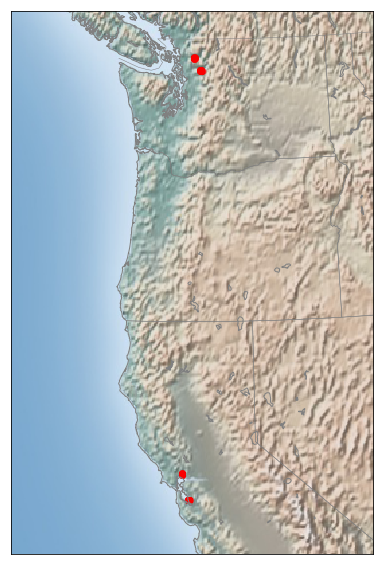

In [9]:
# Visual observation of orchard locations:

GPS=temp[['Latitude','Longitude']].drop_duplicates()
lat = GPS['Latitude'].values
lon = GPS['Longitude'].values

fig = plt.figure(figsize=(10, 10))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=42.971023, lon_0=-122.02576,
            width=1.0E6, height=1.5E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

m.scatter(lon, lat, latlon=True,
          cmap=plt.cm.jet, alpha=0.2, color='red')



Geo locations of the orchards are clustered at four major areas near north-west Washington and north-west Califonia. 
April temperature data, appearing in Celsius, contains missing values and outliers. Following boxplot shows extream temperature values appear in the dataset. To remove outliers, 1.5*IQR approach is used and a resonalbe temperature range between -4.7 and 34.5 Celsius is kept for temperature related calculation and analysis.

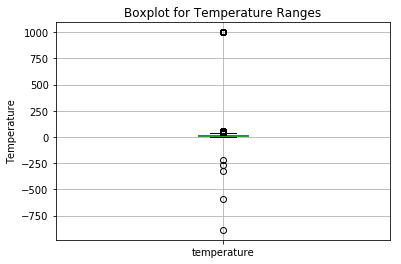

Reasonable Temperature Range: (-4.7, 34.5)


In [11]:
temp.boxplot(column=['temperature'])
plt.ylabel('Temperature')
plt.title('Boxplot for Temperature Ranges')
plt.show()

# 1.5*IQR:
Q75=np.nanpercentile(temp.temperature, 75)
Q25=np.nanpercentile(temp.temperature, 25)

Upper_Temp="{:.3}".format(Q75+(Q75-Q25)*1.5)
Lower_Temp="{:.3}".format(Q25-(Q75-Q25)*1.5)

print("Reasonable Temperature Range:" + " " + "("+ str(Lower_Temp) + ", "+ str(Upper_Temp) +")" )

In [12]:
# Remove temperature outliers
temp_cleaned=temp[(temp.temperature>-4.7) & (temp.temperature<34.5) & ~temp.temperature.isnull()]

In [13]:
# comparing to # of rows started with, outlier removal step removed 8.4% of data
"Data removed as outliers:" +" " + "{:.1%}".format((-temp_cleaned.shape[0]+temp.shape[0])/temp.shape[0])

'Data removed as outliers: 8.8%'

## Q1: What is the average latitude and longitude of all the devices?

In [14]:
# use full data with all device latitude and longtitude information
Location=temp[['device_id', 'Latitude', 'Longitude']].drop_duplicates()

In [15]:
Avg_Latitude="{:.6f}".format(Location.Latitude.mean())
Avg_Longitude="{:.6f}".format(Location.Longitude.mean())

print("Average Latitude: "+Avg_Latitude +', ' +"Average Longitude: "+Avg_Longitude)

Average Latitude: 43.139884, Average Longitude: -122.022637


#### Answer: Average latitude and longitude of all devices installed is (43.139884, -122.022637)

## Q2: What time of day is the hottest? What time of day is the coolest?

In [16]:
# Using data with temperature outliers removed

Avg_temp_by_timeinterval=pd.DataFrame(temp_cleaned.groupby(['PDT_Time']).temperature.mean())
max_temp=max(Avg_temp_by_timeinterval.temperature)
min_temp=min(Avg_temp_by_timeinterval.temperature)

In [17]:
# Average highest temperature (PST) time of the day in April
Avg_temp_by_timeinterval[Avg_temp_by_timeinterval["temperature"]==max_temp]

,temperature
PDT_Time,
15:00:00,21.375772


In [18]:
# Average lowest temperature (PST) time of the day in April
Avg_temp_by_timeinterval[Avg_temp_by_timeinterval["temperature"]==min_temp]

,temperature
PDT_Time,
05:30:00,8.459528


#### Answer: Averagely, 15:00 PDT has the higest temperature (21.394444 Celsius) and 5:30 PDT has the lowest temperature (8.459528 Celsium)

## Q3: Plot the daily high and low temperatures of the devices with ID 19, 138 and 276

In [19]:
# Select data recorded by devices ID-19, 138, 276 from date set with outlier temperature removed

Selected_device=temp_cleaned[temp_cleaned.device_id.isin([19, 138, 276])]

In [21]:
# Find daily maximum/minimum temperature for each device
import dateutil.parser
Daily_max=pd.DataFrame(Selected_device.groupby(['device_id', 'PDT_Date']).temperature.max())
Daily_min=pd.DataFrame(Selected_device.groupby(['device_id', 'PDT_Date']).temperature.min())

# Reset index for graphing
Daily_max.reset_index(level=0, inplace=True)
Daily_min.reset_index(level=0, inplace=True)


Text(0.5, 1.0, 'Daily Maximum Temperature')

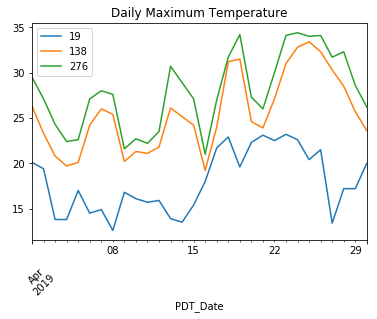

In [22]:
fig, ax = plt.subplots()
for key, data in Daily_max.groupby('device_id'):
    data.plot(y='temperature', ax=ax, label=key)
plt.xticks(rotation=45)
plt.title('Daily Maximum Temperature')

Text(0.5, 1.0, 'Daily Minimum Temperature')

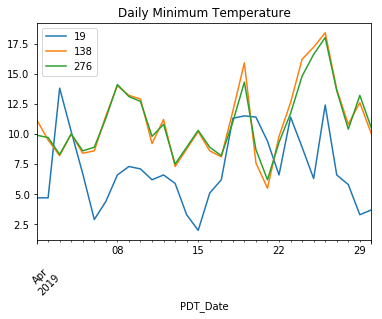

In [23]:
fig, ax = plt.subplots()
for key, data in Daily_min.groupby('device_id'):
    data.plot(y='temperature', ax=ax, label=key)
plt.xticks(rotation=45)
plt.title('Daily Minimum Temperature')

Note: Device ID-138 and ID-276 follow similar patterns on daily max/min temperature during April. Device ID-19 followed very different temperature pattern to the other two devices in April, this is because device ID-19 is not installed in a closer location that the other two devices are installed.

## Q4: Using the data, what was the actual highest temperature in the month of April and where did it occur?

In [24]:
# Using data set with temperature outlier removed

temp_cleaned[temp_cleaned.temperature==max(temp_cleaned.temperature)][['device_id', 'temperature', 'PDT_Date', 'PDT_Time', 'Latitude', 'Longitude']].drop_duplicates()

,device_id,temperature,PDT_Date,PDT_Time,Latitude,Longitude
63682,212,34.4823,2019-04-25,14:40:00,38.237299,-122.338844
63683,212,34.4823,2019-04-25,14:50:00,38.237299,-122.338844
63689,212,34.4823,2019-04-25,15:50:00,38.237299,-122.338844
67994,78,34.4823,2019-04-25,15:20:00,38.227219,-122.347652


#### Answer: Within reasonable temperature range,  April highest temperature 38.237299 was detected on Apriol 25th, at 15:40, 15:50, 16:10 PST at GPS coordinates (38.237299, -122.338844), recorded by device ID-212. Also on same day, at 16:20, recorded at location (38.227219, -122.347652) by device ID-78.

## Q5: Using the data, what was the largest daily temperature swing in the month of April and when did it occur?

The question is interpreted and answered in two ways:
1. Largest daily temperature swing for average daily max/min temperature across all devices
2. Largest daily max/min temperature swing from the data set

In [25]:
# Largest daily temperature swing for average daily max/min temperature across all devices

Avg_temp_across_device=pd.DataFrame(temp_cleaned.groupby(['PDT_Date', 'PDT_Time']).temperature.mean())
# Average daily max/min temperature across all devices 
Avg_daily_max=pd.DataFrame(Avg_temp_across_device.groupby('PDT_Date').max())
Avg_daily_min=pd.DataFrame(Avg_temp_across_device.groupby('PDT_Date').min())

Daily_AvgTemp_Swing=pd.merge(Avg_daily_max, Avg_daily_min, left_index=True, right_index=True)
Daily_AvgTemp_Swing=Daily_AvgTemp_Swing.rename({'temperature_x':'Max_Temperature', 'temperature_y':'Min_Temperature'}, axis=1)

# Calculate temperature swing for daily average temperature 
Daily_AvgTemp_Swing['Temp_Swing']=Daily_AvgTemp_Swing['Max_Temperature']-Daily_AvgTemp_Swing['Min_Temperature']

# Finding largest daily temperature swing based on average temperature across all devices
Daily_AvgTemp_Swing[Daily_AvgTemp_Swing.Temp_Swing==max(Daily_AvgTemp_Swing.Temp_Swing)]

,Max_Temperature,Min_Temperature,Temp_Swing
PDT_Date,,,
2019-04-22,25.409119,7.197555,18.211563


In [26]:
# Largest daily max/min temperature swing from the data set

Regional_Daily_max=pd.DataFrame(temp_cleaned.groupby(['latlng', 'PDT_Date']).temperature.max())
Regional_Daily_min=pd.DataFrame(temp_cleaned.groupby(['latlng', 'PDT_Date']).temperature.min())

Regional_Daily_Swing=pd.merge(Regional_Daily_max, Regional_Daily_min, left_index=True, right_index=True)
Regional_Daily_Swing=Regional_Daily_Swing.rename({'temperature_x':'Max_Temperature', 'temperature_y':'Min_Temperature'}, axis=1)

Regional_Daily_Swing['Temp_Swing']=Regional_Daily_Swing['Max_Temperature']-Regional_Daily_Swing['Min_Temperature']

# Calculate temperature swing for daily average temperature 
Regional_Daily_Swing[Regional_Daily_Swing.Temp_Swing==max(Regional_Daily_Swing.Temp_Swing)]

,,Max_Temperature,Min_Temperature,Temp_Swing
latlng,PDT_Date,,,
37.5762705#-122.0995714,2019-04-28,34.3,6.6,27.7
37.5768414#-122.1349448,2019-04-13,34.3,6.6,27.7


#### Answer: 
1. Largest daily temperature swing in April when calculated using average temperature recorded by all devices is 18.211563 Celsius on 2019-04-22.


2. Largest daily temperature swing in April across all locations is 27.7 Celsius on 2019-04-13 at location (37.5768414, -122.1349448) and on 2019-04-28 at location (37.5762705, -122.0995714)

## Q6: How many different orchards are represented in the data set?

A naive assumption of one monitor device per orchard will return 200 devices at 200 unique locations, and therefore 200 orchards. However, from the earlier Geo-map, it appears all devices are installed with in four main regions -i.e. north-west Washington and north-west Califonia. A natual thought is to conduct a cluster analysis to see if there are Geo locations much closer to each other relative to other locations and results therefore can be used for an educational guess of number of orchards (clusters), given assumption that one orchard could have multiple devices installed.


In [27]:
# Number of devices installed and locations
print('Number of Devices: ' + str(temp.device_id.nunique()))
print('Pairs of Geo Cordinates: ' + str(temp.latlng.nunique()))

Number of Devices: 200
Pairs of Geo Cordinates: 200


Naive guess, there are 200 devices and 200 pair of cordinates, so there are 200 orchards, given naive assumption one device installed per orchart.

##### Clusters analysis:

A dendogram cluster GPS Coordinates into groups. Non-surprisingly, the four regions observed on the map from data exploration created the largest four clusters. Deeper dive-in of data drill out more hidden smaller clusters. As shown in the Geo Coordinate Clusters graph, a total of 8 clusters seem performing well when setting up boundaries between different orchards.

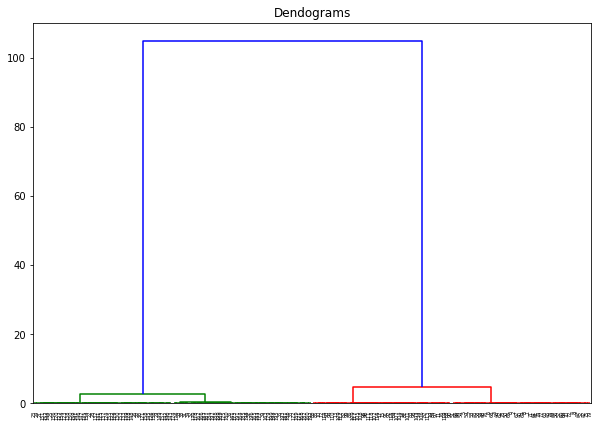

In [28]:
# Dendograms illustrations

cluster_data=temp[['Latitude', 'Longitude']].drop_duplicates().values

plt.figure(figsize=(10, 7))  
plt.title("Dendograms")  
dend = shc.dendrogram(shc.linkage(cluster_data, method='ward')) 

Text(0, 0.5, 'Latitude')

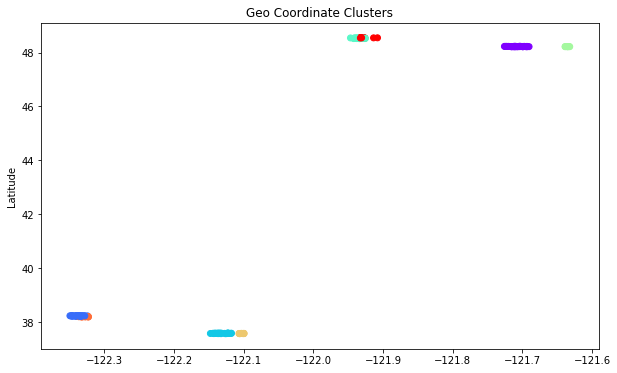

In [29]:
cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')  
cluster.fit_predict(cluster_data)  

plt.figure(figsize=(10, 6))  
plt.scatter(cluster_data[:,1], cluster_data[:,0], c=cluster.labels_, cmap='rainbow') 

plt.title('Geo Coordinate Clusters')
plt.ylabel('Latitude')

#### Answer: 

Using clustering analysis finding natual clusters based on GPS coordinate pairs, a total of eight orchards from four regions of Washington and Califonia are detected within the given data set.